# 3D simulations

Running 3D simulations simply requires to append an extra dimension to all parameters.

In [1]:
from matplotlib import pyplot as plt

from jwave.geometry import Domain
from jwave.utils import show_field, show_positive_field

N, dx = (64, 64, 64), (0.1e-3, 0.1e-3, 0.1e-3)
domain = Domain(N, dx)

In [2]:
from jax import numpy as jnp

from jwave.geometry import Medium, Sensors, TimeAxis, _fibonacci_sphere, _sphere_mask

medium = Medium(domain=domain, sound_speed=1500.0)

time_axis = TimeAxis.from_medium(medium, cfl=0.3)
output_time_axis = TimeAxis(time_axis.dt * 20, time_axis.t_end // 2)

# sensors
num_sensors = 64
x, y, z = _fibonacci_sphere(num_sensors, 20, (32, 32, 32))
sensors_positions = (jnp.array(x), jnp.array(y), jnp.array(z))
sensors = Sensors(positions=sensors_positions)

Text(0.5, 0.92, 'Sensor locations')

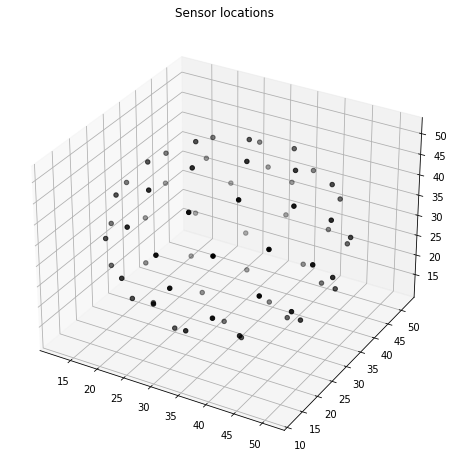

In [3]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection="3d")
ax.scatter(x, y, z, marker="o", color="black")
ax.set_title("Sensor locations")

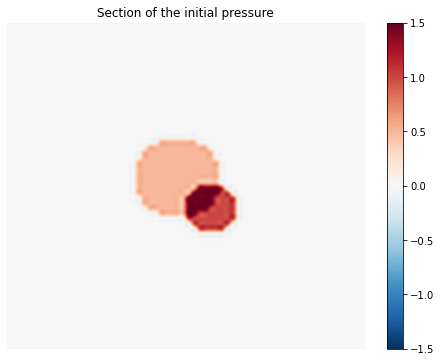

In [4]:
from jwave import FourierSeries
from jwave.utils import show_field

# Initial pressure is a sphere
p0 = jnp.zeros(domain.N)
p0 = (
    _sphere_mask(domain.N, 5, (32, 36, 36)) * 1.0
    + _sphere_mask(domain.N, 8, (32, 30, 30)) * 0.5
)
p0 = jnp.expand_dims(p0, -1)

p0 = FourierSeries(p0, domain)
p0_slice = p0.on_grid[32]

show_field(p0_slice, "Section of the initial pressure")

In [5]:
from jax import jit

from jwave.acoustics import simulate_wave_propagation


@jit
def compiled_simulator(p0):
    return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors)

In [6]:
pressure = compiled_simulator(p0)

Text(0.5, 1.0, 'Sensors traces')

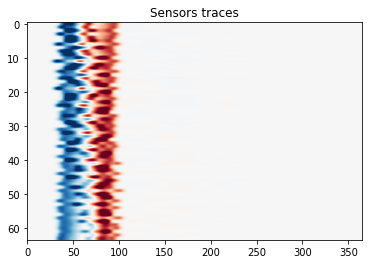

In [7]:
plt.imshow(pressure[..., 0].T, aspect="auto", cmap="RdBu", vmin=-0.1, vmax=0.1)
plt.title("Sensors traces")

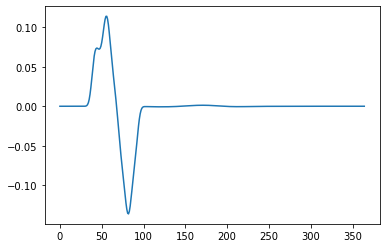

In [9]:
plt.plot(pressure[:, 10])

In [8]:
%timeit compiled_simulator(p0).block_until_ready()

180 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
